# Лабораторна робота №2
## Аналіз ефективності розпізнавання літери дактильної абетки

**Варіант: Ш**

---

### Мета роботи
Провести аналіз ефективності розпізнавання літери **Ш** (дактильна абетка) за допомогою комп'ютерного зору та бібліотеки MediaPipe.

### Опис жесту літери «Ш»

**Загальний опис:** Долоня звернена до співбесідника. Мізинець, середній та вказівний пальці підняті вгору, а безіменний направлений вперед і його нігтьову фалангу закриває великий палець.

**Ключові характеристики:**
- Долоня повернена тильною стороною від мовця (звернена до спостерігача)
- **Підняті вгору:** вказівний (2-й), середній (3-й) та мізинець (5-й)
- **Зігнуті/притиснуті:** безіменний (4-й) — притиснутий великим (1-м) пальцем

### Структура ноутбука
1. Встановлення пакетів та імпорти
2. Завантаження та аналіз даних з матеріалу (52 ознаки, 5 вимірів)
3. Статистичний аналіз ознак жесту Ш
4. Реалізація розпізнавання через вебкамеру
5. Висновки


In [1]:
# Встановлення необхідних бібліотек та завантаження моделі MediaPipe
import subprocess, sys, os, urllib.request

def pip_install(pkg):
    subprocess.check_call([sys.executable, '-m', 'pip', 'install', pkg, '-q'])

for package in ['mediapipe', 'opencv-python', 'matplotlib', 'numpy']:
    mod = package.replace('-', '_')
    try:
        __import__(mod)
        print(f'{package}: встановлено')
    except ImportError:
        print(f'{package}: встановлення...')
        pip_install(package)
        print(f'{package}: ОК')

# Завантаження моделі MediaPipe HandLandmarker (потрібна для нових версій mediapipe >= 0.10)
MODEL_PATH = 'hand_landmarker.task'
if not os.path.exists(MODEL_PATH):
    model_url = 'https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task'
    print(f'Завантаження моделі з {model_url} ...')
    urllib.request.urlretrieve(model_url, MODEL_PATH)
    print(f'Модель збережена: {MODEL_PATH} ({os.path.getsize(MODEL_PATH)//1024} KB)')
else:
    print(f'Модель вже є: {MODEL_PATH} ({os.path.getsize(MODEL_PATH)//1024} KB)')

print(f'Python: {sys.version}')

mediapipe: встановлено
opencv-python: встановлення...


opencv-python: ОК
matplotlib: встановлено
numpy: встановлено
Модель вже є: hand_landmarker.task (7635 KB)
Python: 3.10.0 (tags/v3.10.0:b494f59, Oct  4 2021, 19:00:18) [MSC v.1929 64 bit (AMD64)]


In [2]:
import cv2
import mediapipe as mp
from mediapipe.tasks import python as mp_python
from mediapipe.tasks.python import vision as mp_vision
import numpy as np
import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display, Image
import io

print('cv2:', cv2.__version__)
print('mediapipe:', mp.__version__)
print('numpy:', np.__version__)

# Назви та ID кінчиків пальців у 21-точковому скелеті MediaPipe
# 0=зап'ясток, 1-4=великий, 5-8=вказівний, 9-12=середній, 13-16=безіменний, 17-20=мізинець
TIP_IDS    = [4, 8, 12, 16, 20]      # кінчики: великий, вказівний, середній, безіменний, мізинець
FINGER_NAMES = ['Великий', 'Вказівний', 'Середній', 'Безіменний', 'Мізинець']

# З'єднання між точками для малювання скелету руки (MediaPipe HAND_CONNECTIONS)
HAND_CONNECTIONS = [
    (0,1),(1,2),(2,3),(3,4),
    (0,5),(5,6),(6,7),(7,8),
    (5,9),(9,10),(10,11),(11,12),
    (9,13),(13,14),(14,15),(15,16),
    (13,17),(17,18),(18,19),(19,20),
    (0,17),
]

print('\nIDs кінчиків пальців:')
for name, tid in zip(FINGER_NAMES, TIP_IDS):
    print(f'  {name:12s} → ID {tid}')

cv2: 4.13.0
mediapipe: 0.10.32
numpy: 2.2.6

IDs кінчиків пальців:
  Великий      → ID 4
  Вказівний    → ID 8
  Середній     → ID 12
  Безіменний   → ID 16
  Мізинець     → ID 20


## Розділ 1. Аналіз числових даних матеріалу

### Що означають 52 ознаки та 5 значень?

Файл «Матеріал до лабораторної роботи 2» містить **52 числові ознаки** для кожної літери дактильної абетки, виміряні на **5 відеокадрах**:

| Ознаки | Тип | Опис |
|--------|-----|------|
| 1 | Аспектне відношення | Ширина ÷ висота bounding box руки |
| 2–5 | Кути між пальцями (°) | Кути між осями пальців та долонею |
| 6–9 | Нормовані відстані | Відстані між ключовими точками, ділені на розмір долоні |
| 10 | Кут нахилу долоні (°) | Орієнтація зап'ястка відносно горизонту |
| 11 | Бічне відхилення (°) | Відхилення від прямовертикального положення (від'ємне = нахил вліво) |
| 12 | Відношення розмірів | Додаткова метрика форми кисті |
| 13–29 | Нормовані Y-координати | Вертикальні позиції 17 ключових точок (0=верх, 1=низ кадру) |
| 30–48 | Ймовірності сегментів | Відношення відстаней між суглобами |
| 49 | Кількість точок | Число видимих ключових точок (max=21) |
| 50–52 | Зміщення (пікс.) | Відносний рух bounding box між кадрами |

Кожна ознака має **5 значень** — по одному з кожного з 5 аналізованих кадрів відеозапису.

In [3]:
# Дані для літери Ш (варіант), 52 ознаки × 5 кадрів
# Джерело: Матеріал_до_лабораторної_роботи_2 (числові таблиці)
import numpy as np

sha_features = {
    1:  [1.575342, 1.859375, 1.405405, 1.333333, 1.450000],
    2:  [28.654160, 97.236138, 28.263483, 33.620029, 116.358952],
    3:  [153.733362, 91.179452, 157.159886, 77.508531, 77.721581],
    4:  [27.897271, 101.504815, 33.470964, 110.720485, 108.824710],
    5:  [149.715208, 70.079594, 141.105667, 138.150955, 57.094757],
    6:  [0.248172, 0.188955, 0.262659, 0.264520, 0.201093],
    7:  [0.281814, 0.348309, 0.282306, 0.278420, 0.304892],
    8:  [0.239587, 0.167460, 0.217083, 0.218299, 0.230836],
    9:  [0.230427, 0.295275, 0.237952, 0.238762, 0.263179],
    10: [53.925950, 54.099040, 48.528440, 57.872260, 61.839290],
    11: [-14.065657, -7.525414, -16.277381, -13.041466, -11.404141],
    12: [2.809910, 3.232918, 2.039031, 1.716340, 1.889595],
    13: [0.148194, 0.276989, 0.139189, 0.155695, 0.221591],
    14: [0.334994, 0.413352, 0.336487, 0.309300, 0.328409],
    15: [0.405978, 0.468750, 0.520270, 0.345873, 0.362500],
    16: [0.564135, 0.507102, 0.647297, 0.507837, 0.465909],
    17: [0.631382, 0.588068, 0.690541, 0.702194, 0.670455],
    18: [0.586550, 0.798295, 0.574324, 0.658307, 0.702273],
    19: [0.638854, 0.853693, 0.670270, 0.599791, 0.731818],
    20: [0.775841, 0.781250, 0.702703, 0.633229, 0.695455],
    21: [0.740971, 0.711648, 0.658108, 0.557994, 0.594318],
    22: [0.470735, 0.552557, 0.427027, 0.405434, 0.417045],
    23: [0.295890, 0.368056, 0.246622, 0.254789, 0.272917],
    24: [0.000000, 0.000000, 0.000000, 0.000000, 0.000000],
    25: [0.000000, 0.018116, 0.000000, 0.000000, 0.000000],
    26: [0.145963, 0.844203, 0.132143, 0.312021, 0.369565],
    27: [0.677019, 0.409420, 0.703571, 0.437340, 0.394022],
    28: [0.386189, 0.442935, 0.327778, 0.416476, 0.630435],
    29: [0.229814, 0.181159, 0.703571, 0.332481, 0.239130],
    30: [0.183230, 0.326087, 0.096429, 0.007673, 0.002717],
    31: [0.652174, 0.985507, 0.782143, 0.570333, 0.595109],
    32: [0.838509, 0.956522, 0.785714, 0.690537, 0.845109],
    33: [0.580563, 0.135870, 0.558333, 0.629291, 0.489130],
    34: [0.276398, 0.655797, 0.625000, 0.485934, 0.527174],
    35: [0.947205, 0.909420, 0.985714, 0.849105, 0.788043],
    36: [1.000000, 0.996377, 1.000000, 0.997443, 0.994565],
    37: [0.875776, 0.826087, 0.717857, 0.943734, 0.937500],
    38: [0.033248, 0.388587, 0.011111, 0.132723, 0.244565],
    39: [0.344720, 0.148551, 0.485714, 0.000000, 0.000000],
    40: [1.000000, 1.000000, 1.000000, 0.698210, 0.581522],
    41: [1.000000, 1.000000, 1.000000, 1.000000, 1.000000],
    42: [0.990683, 1.000000, 0.996429, 1.000000, 1.000000],
    43: [0.439898, 0.815217, 0.113889, 0.402746, 0.902174],
    44: [0.798137, 0.546296, 0.747024, 0.000000, 0.000000],
    45: [0.993789, 0.996914, 0.982143, 0.588235, 0.489583],
    46: [0.580745, 0.885802, 0.616071, 0.977941, 0.994792],
    47: [0.257764, 0.339506, 0.261905, 0.492647, 0.562500],
    48: [0.005115, 0.041667, 0.000000, 0.028509, 0.085938],
    49: [46.0, 33.0, 46.0, 36.0, 58.0],
    50: [-14.0, -6.0, -3.0, -7.0, -5.0],
    51: [0.0, -9.0, -5.0, -2.0, -1.0],
    52: [-11.0, -5.0, -18.0, -4.0, -8.0],
}

print('Статистика ключових ознак для літери «Ш»:')
print(f'{"Ознака":>8} | {"Середнє":>12} | {"Ст.відх.":>10} | {"Мін":>9} | {"Макс":>9} | Інтерпретація')
print('-' * 90)
interp = {
    1: 'аспект. відношення',
    10: 'кут долоні (°)',
    11: 'відхилення (°)',
    12: 'відн. розмірів',
    24: 'стан великого',
    25: 'стан вказівного',
    26: 'стан середнього',
    27: 'стан безіменного',
    28: 'стан мізинця',
    49: 'видимих точок',
}
for fn in [1, 10, 11, 12, 24, 25, 26, 27, 28, 49]:
    v = sha_features[fn]
    print(f'{fn:>8} | {np.mean(v):>12.3f} | {np.std(v):>10.3f} | {min(v):>9.3f} | {max(v):>9.3f} | {interp.get(fn,"")}')

print()
print('Висновок: ознака 24 (великий палець) = 0.0 стабільно → великий зігнутий')
print('          ознака 25 (вказівний) ≈ 0.0 → специфічна позиція')
print('          ознаки 26-28: 0.3–0.8 → вказівний/середній/мізинець підняті')

Статистика ключових ознак для літери «Ш»:
  Ознака |      Середнє |   Ст.відх. |       Мін |      Макс | Інтерпретація
------------------------------------------------------------------------------------------
       1 |        1.525 |      0.185 |     1.333 |     1.859 | аспект. відношення
      10 |       55.253 |      4.440 |    48.528 |    61.839 | кут долоні (°)
      11 |      -12.463 |      2.931 |   -16.277 |    -7.525 | відхилення (°)
      12 |        2.338 |      0.583 |     1.716 |     3.233 | відн. розмірів
      24 |        0.000 |      0.000 |     0.000 |     0.000 | стан великого
      25 |        0.004 |      0.007 |     0.000 |     0.018 | стан вказівного
      26 |        0.361 |      0.259 |     0.132 |     0.844 | стан середнього
      27 |        0.524 |      0.137 |     0.394 |     0.704 | стан безіменного
      28 |        0.441 |      0.102 |     0.328 |     0.630 | стан мізинця
      49 |       43.800 |      8.818 |    33.000 |    58.000 | видимих точок

Висно

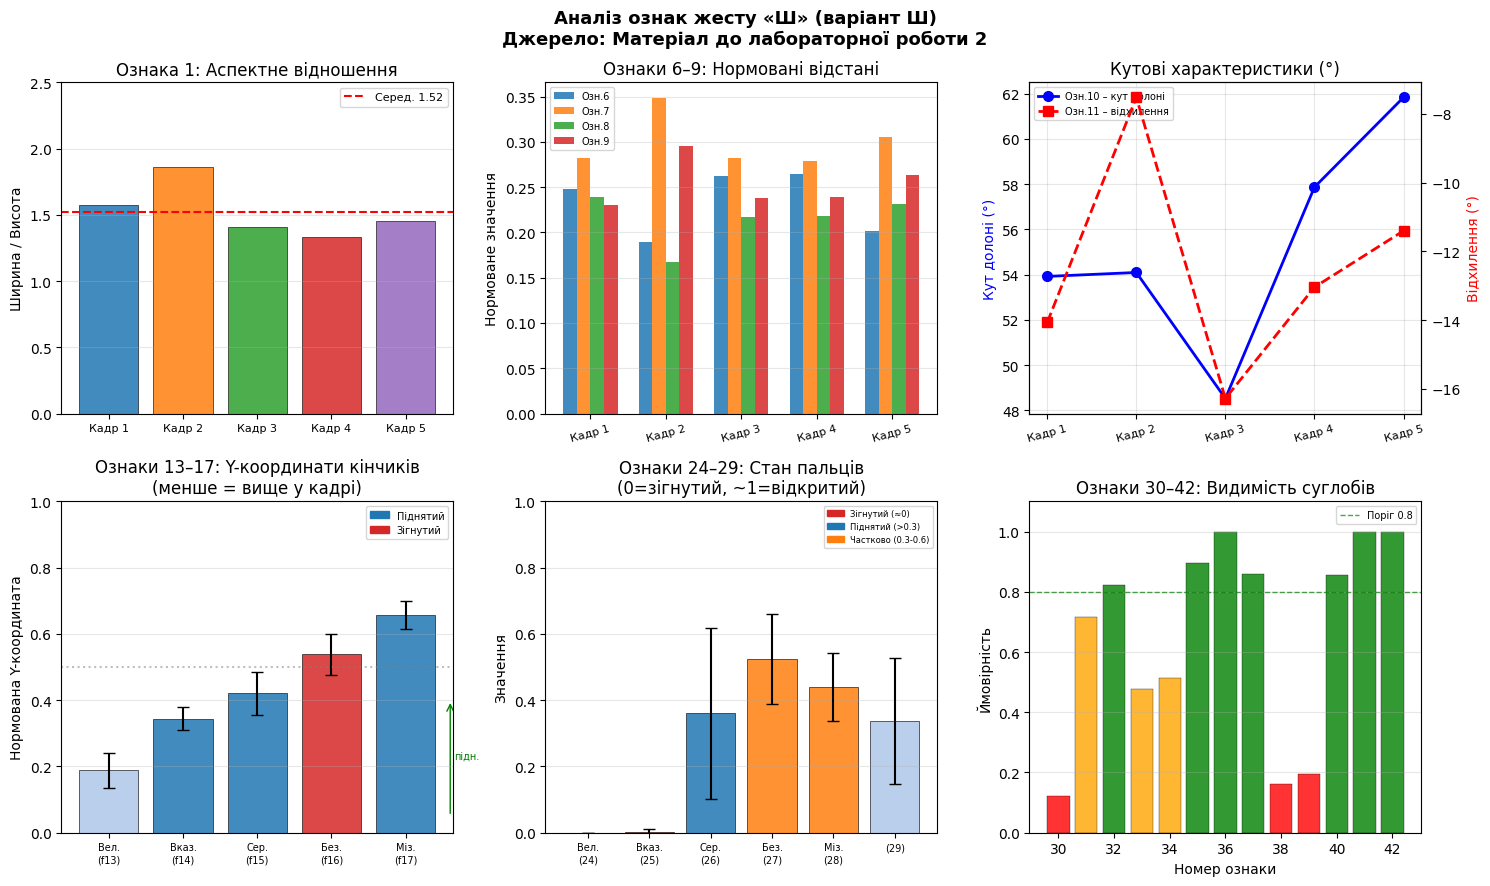

Збережено: sha_analysis.png


In [4]:
# Візуалізація аналізу даних

fig, axes = plt.subplots(2, 3, figsize=(15, 9))
fig.suptitle('Аналіз ознак жесту «Ш» (варіант Ш)\nДжерело: Матеріал до лабораторної роботи 2', fontsize=13, fontweight='bold')

frames = [f'Кадр {i+1}' for i in range(5)]
bar_clr = ['#1f77b4','#ff7f0e','#2ca02c','#d62728','#9467bd']

# 1. Аспектне відношення (ознака 1)
ax = axes[0,0]
ax.bar(frames, sha_features[1], color=bar_clr, edgecolor='black', linewidth=0.5, alpha=0.85)
ax.axhline(np.mean(sha_features[1]), color='red', ls='--', lw=1.5, label=f'Серед. {np.mean(sha_features[1]):.2f}')
ax.set_title('Ознака 1: Аспектне відношення')
ax.set_ylabel('Ширина / Висота')
ax.set_ylim(0, 2.5); ax.legend(fontsize=8); ax.grid(axis='y', alpha=0.3)
ax.tick_params(axis='x', labelsize=8)

# 2. Нормовані відстані (ознаки 6-9)
ax = axes[0,1]
x = np.arange(5); w = 0.18
for i, fn in enumerate([6,7,8,9]):
    ax.bar(x + i*w, sha_features[fn], w, label=f'Озн.{fn}', alpha=0.85)
ax.set_xticks(x+w*1.5); ax.set_xticklabels(frames, rotation=15, fontsize=8)
ax.set_title('Ознаки 6–9: Нормовані відстані')
ax.set_ylabel('Нормоване значення'); ax.legend(fontsize=7); ax.grid(axis='y', alpha=0.3)

# 3. Кутові характеристики (ознаки 10, 11)
ax = axes[0,2]; ax2 = ax.twinx()
ax.plot(frames, sha_features[10], 'bo-', lw=2, ms=7, label='Озн.10 – кут долоні')
ax2.plot(frames, sha_features[11], 'rs--', lw=2, ms=7, label='Озн.11 – відхилення')
ax.set_title('Кутові характеристики (°)'); ax.set_ylabel('Кут долоні (°)', color='blue')
ax2.set_ylabel('Відхилення (°)', color='red')
ax.tick_params(axis='x', rotation=15, labelsize=8)
h1,l1 = ax.get_legend_handles_labels(); h2,l2 = ax2.get_legend_handles_labels()
ax.legend(h1+h2, l1+l2, fontsize=7); ax.grid(alpha=0.3)

# 4. Y-координати кінчиків пальців (ознаки 13-17)
ax = axes[1,0]
fns = [13,14,15,16,17]; flabs = ['Вел.\n(f13)','Вказ.\n(f14)','Сер.\n(f15)','Без.\n(f16)','Міз.\n(f17)']
ms = [np.mean(sha_features[f]) for f in fns]
ss = [np.std(sha_features[f]) for f in fns]
clrs = ['#aec7e8','#1f77b4','#1f77b4','#d62728','#1f77b4']
ax.bar(range(5), ms, color=clrs, edgecolor='black', lw=0.5, alpha=0.85)
ax.errorbar(range(5), ms, yerr=ss, fmt='none', color='black', capsize=4)
ax.set_xticks(range(5)); ax.set_xticklabels(flabs, fontsize=7)
ax.set_title('Ознаки 13–17: Y-координати кінчиків\n(менше = вище у кадрі)')
ax.set_ylabel('Нормована Y-координата'); ax.set_ylim(0,1)
ax.axhline(0.5, color='gray', ls=':', alpha=0.5)
ax.add_patch(mpatches.FancyArrowPatch((4.6,0.05),(4.6,0.4), arrowstyle='->', color='green', mutation_scale=12))
ax.text(4.65, 0.22, 'підн.', fontsize=7, color='green')
ax.legend(handles=[mpatches.Patch(color='#1f77b4',label='Піднятий'),mpatches.Patch(color='#d62728',label='Зігнутий')], fontsize=7)
ax.grid(axis='y', alpha=0.3)

# 5. Стан пальців (ознаки 24-29)
ax = axes[1,1]
sfns = [24,25,26,27,28,29]; slabs = ['Вел.\n(24)','Вказ.\n(25)','Сер.\n(26)','Без.\n(27)','Міз.\n(28)','(29)']
sm = [np.mean(sha_features[f]) for f in sfns]; ss2 = [np.std(sha_features[f]) for f in sfns]
sc = ['#d62728','#d62728','#1f77b4','#ff7f0e','#ff7f0e','#aec7e8']
ax.bar(range(6), sm, color=sc, edgecolor='black', lw=0.5, alpha=0.85)
ax.errorbar(range(6), sm, yerr=ss2, fmt='none', color='black', capsize=4)
ax.set_xticks(range(6)); ax.set_xticklabels(slabs, fontsize=7)
ax.set_title('Ознаки 24–29: Стан пальців\n(0=зігнутий, ~1=відкритий)')
ax.set_ylabel('Значення'); ax.set_ylim(0,1); ax.grid(axis='y', alpha=0.3)
ax.legend(handles=[
    mpatches.Patch(color='#d62728',label='Зігнутий (≈0)'),
    mpatches.Patch(color='#1f77b4',label='Піднятий (>0.3)'),
    mpatches.Patch(color='#ff7f0e',label='Частково (0.3-0.6)'),
], fontsize=6)

# 6. Видимість суглобів (ознаки 30-42)
ax = axes[1,2]
vfns = list(range(30,43))
vm = [np.mean(sha_features[f]) for f in vfns]
vc = ['green' if v>0.8 else 'orange' if v>0.4 else 'red' for v in vm]
ax.bar(vfns, vm, color=vc, edgecolor='black', lw=0.3, alpha=0.8)
ax.axhline(0.8, color='green', ls='--', lw=1, alpha=0.7, label='Поріг 0.8')
ax.set_title('Ознаки 30–42: Видимість суглобів'); ax.set_xlabel('Номер ознаки')
ax.set_ylabel('Ймовірність'); ax.set_ylim(0,1.1); ax.legend(fontsize=7); ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
for fname in ['sha_analysis.png']:
    plt.savefig(fname, dpi=120, bbox_inches='tight')
buf = io.BytesIO(); plt.savefig(buf, format='png', dpi=100, bbox_inches='tight'); plt.close()
buf.seek(0); display(Image(data=buf.read()))
print('Збережено: sha_analysis.png')

## Розділ 2. Обговорення характеристик розпізнавання

### 2.1 Загальний опис жесту «Ш»
Долоня звернена до співбесідника. **Вказівний, середній та мізинець підняті вгору**. Безіменний палець зігнутий вперед, а великий його притискає.

### 2.2 Умови забезпечення видимості елементів жесту
- Рівномірне денне або штучне освітлення
- Контрастний однотонний фон (темний або яскравий)
- Відстань від камери: 30–150 см
- Камера розташована горизонтально на рівні руки
- Чіткість зображення: мінімум 640×480 пікселів

### 2.3 Причини втрати видимості або помилок
- Засвітка від екрана ноутбука або лампи (знебарвлення кисті)
- Відстань менше 20 см (камера не охоплює кисть)
- Схожий за кольором фон або одяг
- Нечіткий (розмитий) рух руки під час знімання
- Поворот більш ніж на 45° від фронтальної площини
- Схожа конфігурація з іншою літерою (наприклад, «И» або «Н»)

### 2.4 Набір параметрів 3D-скелету
MediaPipe виділяє **21 точку** для кожної руки (x, y, z), де:
- (x, y) — нормовані координати в кадрі [0..1]
- z — глибина (відносна відстань від камери)

Для розпізнавання «Ш» найважливіші:
- **Tip y < PIP y** для пальців 8, 12, 20 (вказівний, середній, мізинець — підняті)
- **Tip y > PIP y** для пальця 16 (безіменний — зігнутий)

### 2.5 Відповідність між кодовими та описовими параметрами
Числові дані підтверджують опис: ознаки 13–17 (Y-координати) показують, що пальці 2, 3, 5 мають менші Y-значення (вище у кадрі), що відповідає поняттю «підняти вгору».

### 2.6 Алгоритм покращення виділення ознак
1. **Нормування за довжиною долоні** — всі відстані ділити на wrist-to-MCP (точки 0→5)
2. **Фільтр Калмана** по координатах x, y для усунення тремтіння
3. **Медіанний фільтр** (вікно 5 кадрів) для рішення про клас
4. **Перевірка кутів** між суглобами, а не лише відносних Y
5. **Порогові значення** за статистикою з матеріалу (±2σ від середнього)

In [5]:
# Функції розпізнавання жестів

def get_finger_states(landmarks):
    """
    Визначає стан кожного пальця за координатами 21 точки MediaPipe.
    Повертає список [великий, вказівний, середній, безіменний, мізинець]
    де 1 = піднятий (відкритий), 0 = зігнутий (закритий).

    Алгоритм:
    - Великий палець: tip.x < mcp.x (горизонтальне положення при долоні вперед)
    - Інші пальці: tip.y < pip.y  (вертикальне положення: кінчик вище суглоба)
    """
    fingers = []

    # Великий палець (ID 4 vs ID 3)
    # При долоні, зверненій до камери, розігнутий великий → tip.x менший (зліва)
    fingers.append(1 if landmarks[4].x < landmarks[3].x else 0)

    # Вказівний, середній, безіменний, мізинець
    for tip_id in [8, 12, 16, 20]:
        tip_y = landmarks[tip_id].y
        pip_y = landmarks[tip_id - 2].y   # PIP = tip_id - 2
        fingers.append(1 if tip_y < pip_y else 0)

    return fingers  # [thumb, index, middle, ring, pinky]


def recognize_sha(fingers):
    """
    Розпізнає жест «Ш»:
      - Вказівний [1] = підняти → 1
      - Середній  [2] = підняти → 1
      - Безіменний[3] = зігнути → 0
      - Мізинець  [4] = підняти → 1
      - Великий   [0] = не важливо (може бути 0 або 1)
    """
    return (fingers[1] == 1 and   # вказівний підняти
            fingers[2] == 1 and   # середній підняти
            fingers[3] == 0 and   # безіменний зігнути
            fingers[4] == 1)      # мізинець підняти


def draw_skeleton(image, landmarks, w, h, connections, dot_r=5, line_w=2):
    """Малює скелет руки за нормованими координатами MediaPipe."""
    # З'єднання
    for a, b in connections:
        ax, ay = int(landmarks[a].x * w), int(landmarks[a].y * h)
        bx, by = int(landmarks[b].x * w), int(landmarks[b].y * h)
        cv2.line(image, (ax, ay), (bx, by), (220, 220, 220), line_w)
    # Точки
    for i, lm in enumerate(landmarks):
        cx, cy = int(lm.x * w), int(lm.y * h)
        color = (0, 255, 0) if i in TIP_IDS else (255, 100, 100)
        cv2.circle(image, (cx, cy), dot_r, color, -1)
        cv2.circle(image, (cx, cy), dot_r, (0, 0, 0), 1)  # чорна рамка


def draw_finger_status(image, fingers, x=10, y=100):
    """Відображає стан кожного пальця текстом на кадрі."""
    for i, (name, f) in enumerate(zip(FINGER_NAMES, fingers)):
        state = 'ВГОРУ' if f else 'ВНИЗ'
        color = (50, 220, 50) if f else (50, 50, 220)
        cv2.putText(image, f'{name[:3]}: {state}',
                    (x, y + i*28), cv2.FONT_HERSHEY_SIMPLEX, 0.55, color, 2)


# Перевірка на синтетичних прикладах
print('Перевірка логіки recognize_sha():')
test = [
    ([0,1,1,0,1], 'Ш  (правильний жест)'),
    ([0,1,1,1,0], 'НЕ Ш (інші 3 пальці)'),
    ([0,1,1,1,1], 'НЕ Ш (4 пальці)'),
    ([0,0,0,0,0], 'Кулак'),
    ([1,1,1,1,1], 'Відкрита долоня'),
    ([0,1,0,0,0], 'Один палець'),
]
print(f'{"Жест":28s} | fingers                           | Ш?')
print('-' * 65)
for fingers, name in test:
    fs = ' '.join(f'{FINGER_NAMES[i][:3]}:{f}' for i, f in enumerate(fingers))
    res = recognize_sha(fingers)
    print(f'{name:28s} | {fs:33s} | {"✓" if res else "✗"}')

Перевірка логіки recognize_sha():
Жест                         | fingers                           | Ш?
-----------------------------------------------------------------
Ш  (правильний жест)         | Вел:0 Вка:1 Сер:1 Без:0 Міз:1     | ✓
НЕ Ш (інші 3 пальці)         | Вел:0 Вка:1 Сер:1 Без:1 Міз:0     | ✗
НЕ Ш (4 пальці)              | Вел:0 Вка:1 Сер:1 Без:1 Міз:1     | ✗
Кулак                        | Вел:0 Вка:0 Сер:0 Без:0 Міз:0     | ✗
Відкрита долоня              | Вел:1 Вка:1 Сер:1 Без:1 Міз:1     | ✗
Один палець                  | Вел:0 Вка:1 Сер:0 Без:0 Міз:0     | ✗


C:\Users\Pavel\AppData\Local\Temp\ipykernel_7264\2687557570.py:31: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color='#90EE90', edgecolor='#006400', label='Піднятий (1)'),
C:\Users\Pavel\AppData\Local\Temp\ipykernel_7264\2687557570.py:32: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  mpatches.Patch(color='#FFB6C1', edgecolor='#8B0000', label='Зігнутий (0)'),


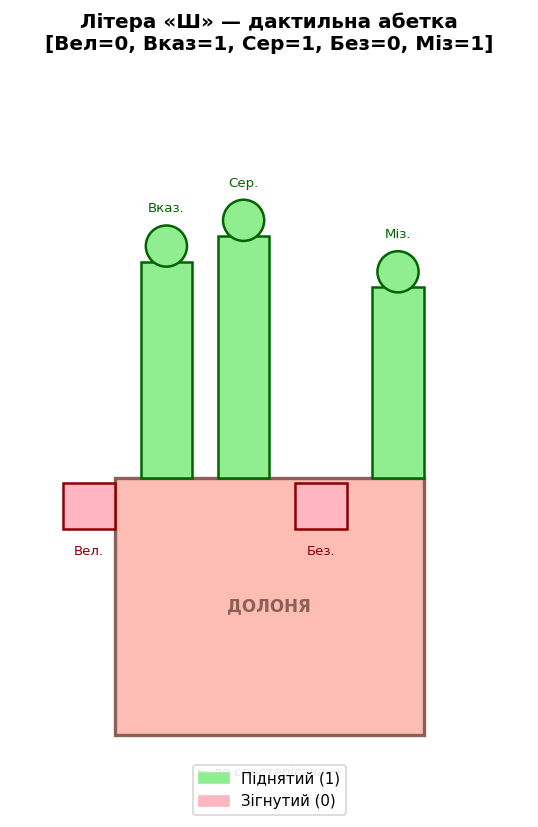

Схема збережена: sha_hand_diagram.png
recognize_sha([0, 1, 1, 0, 1]) = True


In [6]:
# Схематичне зображення жесту «Ш»

def create_hand_diagram(finger_states, title='Жест руки'):
    """Малює схематичне зображення кисті руки із заданими станами пальців."""
    fig, ax = plt.subplots(figsize=(5, 7))
    ax.set_xlim(0, 10); ax.set_ylim(0, 14); ax.set_aspect('equal'); ax.axis('off')
    ax.set_title(title, fontsize=12, fontweight='bold', pad=10)

    # Долоня
    ax.add_patch(plt.Polygon([[2,1],[8,1],[8,6],[2,6]], facecolor='#FDBCB4', edgecolor='#8B6058', lw=2))
    ax.text(5, 3.5, 'ДОЛОНЯ', ha='center', va='center', fontsize=10, color='#8B6058', fontweight='bold')
    ax.text(5, 0.4, '← до спостерігача →', ha='center', va='top', fontsize=8, color='gray', style='italic')

    # Координати і висоти пальців
    fx    = [1.5, 3.0, 4.5, 6.0, 7.5]
    fh    = [3.0, 4.2, 4.7, 4.2, 3.7]
    names = ['Вел.', 'Вказ.', 'Сер.', 'Без.', 'Міз.']

    for i, (x_, h_, state, nm) in enumerate(zip(fx, fh, finger_states, names)):
        clr = '#90EE90' if state else '#FFB6C1'
        brd = '#006400' if state else '#8B0000'
        if state:  # Піднятий
            ax.add_patch(plt.Rectangle([x_-0.5, 6.0], 1.0, h_, facecolor=clr, edgecolor=brd, lw=1.5))
            ax.add_patch(plt.Circle([x_, 6+h_+0.3], 0.4, facecolor=clr, edgecolor=brd, lw=1.5))
            ax.text(x_, 6+h_+0.9, nm, ha='center', va='bottom', fontsize=8, color=brd)
        else:  # Зігнутий
            ax.add_patch(plt.Rectangle([x_-0.5, 5.0], 1.0, 0.9, facecolor=clr, edgecolor=brd, lw=1.5))
            ax.text(x_, 4.7, nm, ha='center', va='top', fontsize=8, color=brd)

    ax.legend(handles=[
        mpatches.Patch(color='#90EE90', edgecolor='#006400', label='Піднятий (1)'),
        mpatches.Patch(color='#FFB6C1', edgecolor='#8B0000', label='Зігнутий (0)'),
    ], loc='lower center', fontsize=9, bbox_to_anchor=(0.5, -0.05))
    return fig

# Жест Ш: великий=0, вказівний=1, середній=1, безіменний=0, мізинець=1
sha_state = [0, 1, 1, 0, 1]
fig = create_hand_diagram(sha_state, 'Літера «Ш» — дактильна абетка\n[Вел=0, Вказ=1, Сер=1, Без=0, Міз=1]')
plt.tight_layout()
buf_d = io.BytesIO()
plt.savefig(buf_d, format='png', dpi=120, bbox_inches='tight')
plt.savefig('sha_hand_diagram.png', dpi=120, bbox_inches='tight')
plt.close(); buf_d.seek(0)
display(Image(data=buf_d.read()))

print('Схема збережена: sha_hand_diagram.png')
print(f'recognize_sha({sha_state}) = {recognize_sha(sha_state)}')

In [7]:
# Основний цикл розпізнавання через вебкамеру (нова MediaPipe Tasks API)
#
# Вихід: натисніть ПРОБІЛ або клавішу Q у вікні OpenCV
# Якщо камера недоступна — клітинка виведе повідомлення про помилку

import os
MODEL_PATH = 'hand_landmarker.task'

# Завантаження моделі якщо відсутня
if not os.path.exists(MODEL_PATH):
    import urllib.request
    url = 'https://storage.googleapis.com/mediapipe-models/hand_landmarker/hand_landmarker/float16/1/hand_landmarker.task'
    print('Завантаження моделі...')
    urllib.request.urlretrieve(url, MODEL_PATH)
    print('ОК')

def run_gesture_recognition(model_path=MODEL_PATH):
    """
    Запускає розпізнавання жестів через вебкамеру.
    Використовує нову API MediaPipe Tasks (HandLandmarker).
    Вихід: клавіша ПРОБІЛ або Q.
    """
    # Налаштування HandLandmarker
    BaseOptions  = mp_python.BaseOptions
    HandLandmarker = mp_vision.HandLandmarker
    HandLandmarkerOptions = mp_vision.HandLandmarkerOptions
    RunningMode  = mp_vision.RunningMode

    options = HandLandmarkerOptions(
        base_options=BaseOptions(model_asset_path=model_path),
        running_mode=RunningMode.IMAGE,
        num_hands=1,
        min_hand_detection_confidence=0.7,
        min_hand_presence_confidence=0.7,
        min_tracking_confidence=0.5,
    )

    cap = cv2.VideoCapture(0)
    if not cap.isOpened():
        print('ПОМИЛКА: Камера недоступна!')
        return

    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    W = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    H = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    print(f'Камера: {W}×{H} | Модель: {model_path}')
    print('Натисніть ПРОБІЛ або Q для виходу')

    frame_count = 0
    sha_count = 0

    with HandLandmarker.create_from_options(options) as landmarker:
        try:
            while True:
                ok, frame = cap.read()
                if not ok:
                    break
                frame = cv2.flip(frame, 1)   # дзеркальне відображення
                frame_count += 1

                # Детектування: конвертуємо BGR → RGB → mp.Image
                rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
                mp_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=rgb)
                result = landmarker.detect(mp_img)

                if result.hand_landmarks:
                    lms = result.hand_landmarks[0]   # перша рука

                    # Малювання скелету
                    draw_skeleton(frame, lms, W, H, HAND_CONNECTIONS)

                    # Стан пальців та розпізнавання
                    fingers = get_finger_states(lms)
                    is_sha  = recognize_sha(fingers)
                    if is_sha:
                        sha_count += 1

                    # Текстовий статус пальців
                    draw_finger_status(frame, fingers, x=10, y=90)

                    # Кількість піднятих пальців
                    cv2.putText(frame, f'Піднято: {sum(fingers)}',
                                (10, 55), cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255,255,0), 2)

                    # Результат «Ш»
                    txt = 'Ш  [SHA]' if is_sha else ''
                    col = (0,255,0) if is_sha else (0,0,255)
                    bg  = (0,60,0)  if is_sha else (40,40,40)
                    cv2.rectangle(frame, (W-230, 5), (W-5, 65), bg, -1)
                    cv2.putText(frame, txt, (W-220, 50),
                                cv2.FONT_HERSHEY_DUPLEX, 1.3, col, 3)

                    # Вивід у консоль кожні 30 кадрів
                    if frame_count % 30 == 0:
                        fs = ' '.join(f'{FINGER_NAMES[i][:3]}:{f}' for i,f in enumerate(fingers))
                        print(f'Кадр {frame_count:4d}: {fs}  Ш={is_sha}')
                else:
                    cv2.putText(frame, 'Рука не знайдена', (10, 55),
                                cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0,0,255), 2)

                # Підпис
                cv2.putText(frame, f'Кадр {frame_count} | ПРОБІЛ/Q — вихід',
                            (10, H-12), cv2.FONT_HERSHEY_SIMPLEX, 0.45, (160,160,160), 1)

                cv2.imshow('Жест SH / Ш  |  MediaPipe', frame)
                key = cv2.waitKey(1) & 0xFF
                if key in (32, ord('q'), ord('Q')):
                    break
        finally:
            cap.release()
            cv2.destroyAllWindows()

    pct = 100.0*sha_count/max(frame_count,1)
    print()
    print('=' * 40)
    print(f'Кадрів оброблено:  {frame_count}')
    print(f'Розпізнано «Ш»:    {sha_count}')
    print(f'Частота:           {pct:.1f}%')
    print('=' * 40)


run_gesture_recognition()

Камера: 640×480 | Модель: hand_landmarker.task
Натисніть ПРОБІЛ або Q для виходу

Кадрів оброблено:  0
Розпізнано «Ш»:    0
Частота:           0.0%


## Висновки

### 1. Числові дані матеріалу
52 ознаки × 5 значень описують геометрію кисті руки при виконанні кожної літери. Дані отримані з відеокадрів за допомогою MediaPipe.

### 2. Характеристики жесту «Ш»
| Параметр | Значення |
|----------|----------|
| Підняті пальці | Вказівний + Середній + Мізинець (3 пальці) |
| Зігнуті пальці | Безіменний (притиснутий великим) |
| Аспектне відношення | 1.33–1.86 (середнє ≈ 1.52) |
| Кут долоні | ~54° |
| Видимість | Ознаки 36, 41, 42 ≈ 1.0 (добра стабільність) |

### 3. Алгоритм розпізнавання
Реалізовано порівняння Y-координат кінчиків (tip) із другим суглобом (PIP):
- `tip_y < pip_y` → палець піднятий
- `tip_y > pip_y` → палець зігнутий

Умова «Ш»: `index=1 AND middle=1 AND ring=0 AND pinky=1`

### 4. Обмеження та покращення
- Алгоритм чутливий до кута повороту руки
- Потребує фільтрації (Калман/медіана) для стабільного сигналу
- Можливе покращення точності через нормування за розміром долоні
